In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *

import seaborn as sns
sns.set_style('whitegrid')


# Comparison of plot characteristics and digitized deadwood

## Hiidenportti

Read data and do some wrangling.

In [2]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_variables.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
natura_areas = gpd.read_file(field_data_path/'hiidenportti_natura.geojson')

In [3]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
deadwood_cols = dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

Convert `n_dw` (number of deadwood stems per hectare) to signify number of deadwood stems in circular plot with 9m radius.

In [5]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)

In [6]:
def match_circular_plot(row, plots):
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)

In [7]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns.overlay(plot_circles)
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [10]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(natura_areas.geometry.contains(row.geometry))
                                                  else 0, axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


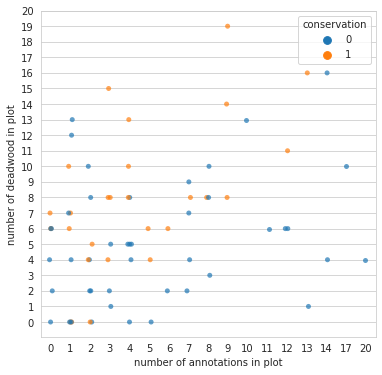

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
g = sns.scatterplot(data=plot_dw_data, x='n_dw_ann', y='n_dw_plot', hue='conservation', ax=ax, alpha=0.4)
g.set_xticks(range(0,21))
g.set_yticks(range(0,21))
g.set_ylabel('number of deadwood in plot')
g.set_xlabel('number of annotations in plot')
plt.show()

Plot the relationship between annotated deadwood and field-measured deadwood. The darker a single dot is, the more plots are located in that point.

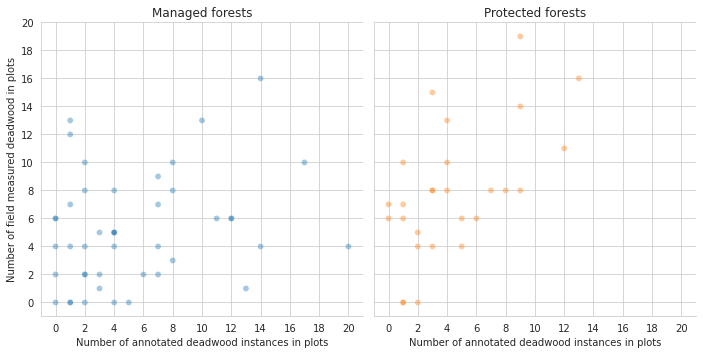

In [103]:
g = sns.relplot(data=plot_dw_data, x='n_dw_ann', y='n_dw_plot', col='conservation', hue='conservation', alpha=.4,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,21,2))
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
g.set_ylabels('Number of field measured deadwood in plots')
g.set_xlabels('Number of annotated deadwood instances in plots')

Read individual tree measurements, and convert `l` from decimeters to meters.

In [104]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Plot the distribution of field measured groundwood lengths.

In [133]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

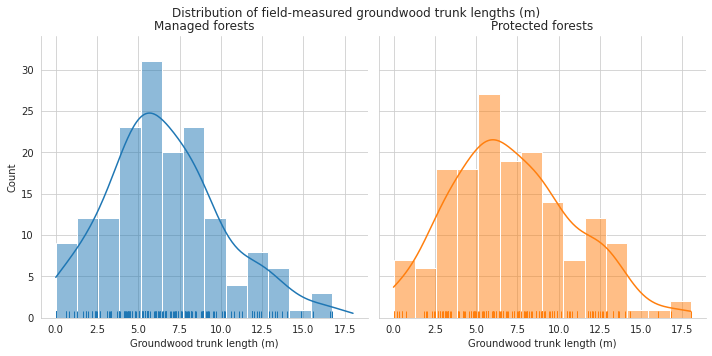

In [137]:
g = sns.displot(data=tree_data[tree_data.tree_class == 4], x='l', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

For annotated groundwood, as the annotations can be twisted due to e.g. orthorectification errors, we use the longest side of the smallest rotated rectangle that can be fit around the polygon as a proxy for the trunk length.

<AxesSubplot:>

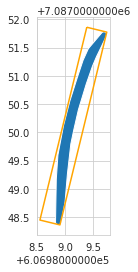

In [119]:
ix = 18
fig, ax = plt.subplots(1,1)
anns_in_plots[ix:ix+1].plot(ax=ax)
temp = anns_in_plots[ix:ix+1].copy()
temp['geometry'] = temp.apply(lambda row: row.geometry.minimum_rotated_rectangle, axis=1)
temp.exterior.plot(ax=ax, color='orange')

In [36]:
def get_len(geom):
    "Use the longest side of the minimum rotated rectangle around a polygon as the proxy for trunk length"
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

In [37]:
anns_in_plots['tree_length'] = anns_in_plots.geometry.apply(get_len)

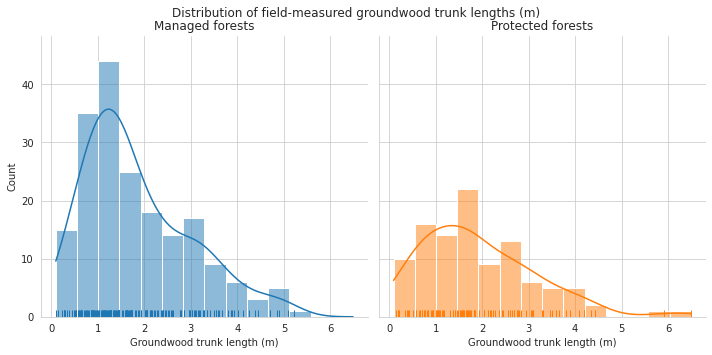

In [138]:
g = sns.displot(data=anns_in_plots[anns_in_plots.layer_1=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

In [141]:
plot_dw_data['n_dw_stand_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                                (tree_data.tree_class == 3)]),
                                                      axis=1)
plot_dw_data['n_dw_fall_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                               ((tree_data.tree_class == 4)|
                                                                                (tree_data.tree_class == 5))]),
                                                     axis=1)
plot_dw_data['n_dw_stand_ann'] = plot_dw_data.apply(lambda row: len(anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                                  (anns_in_plots.layer_1 != 'groundwood')]),
                                                    axis=1)
plot_dw_data['n_dw_fall_ann'] = plot_dw_data.apply(lambda row: len(anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                                 (anns_in_plots.layer_1 == 'groundwood')]),
                                                    axis=1)

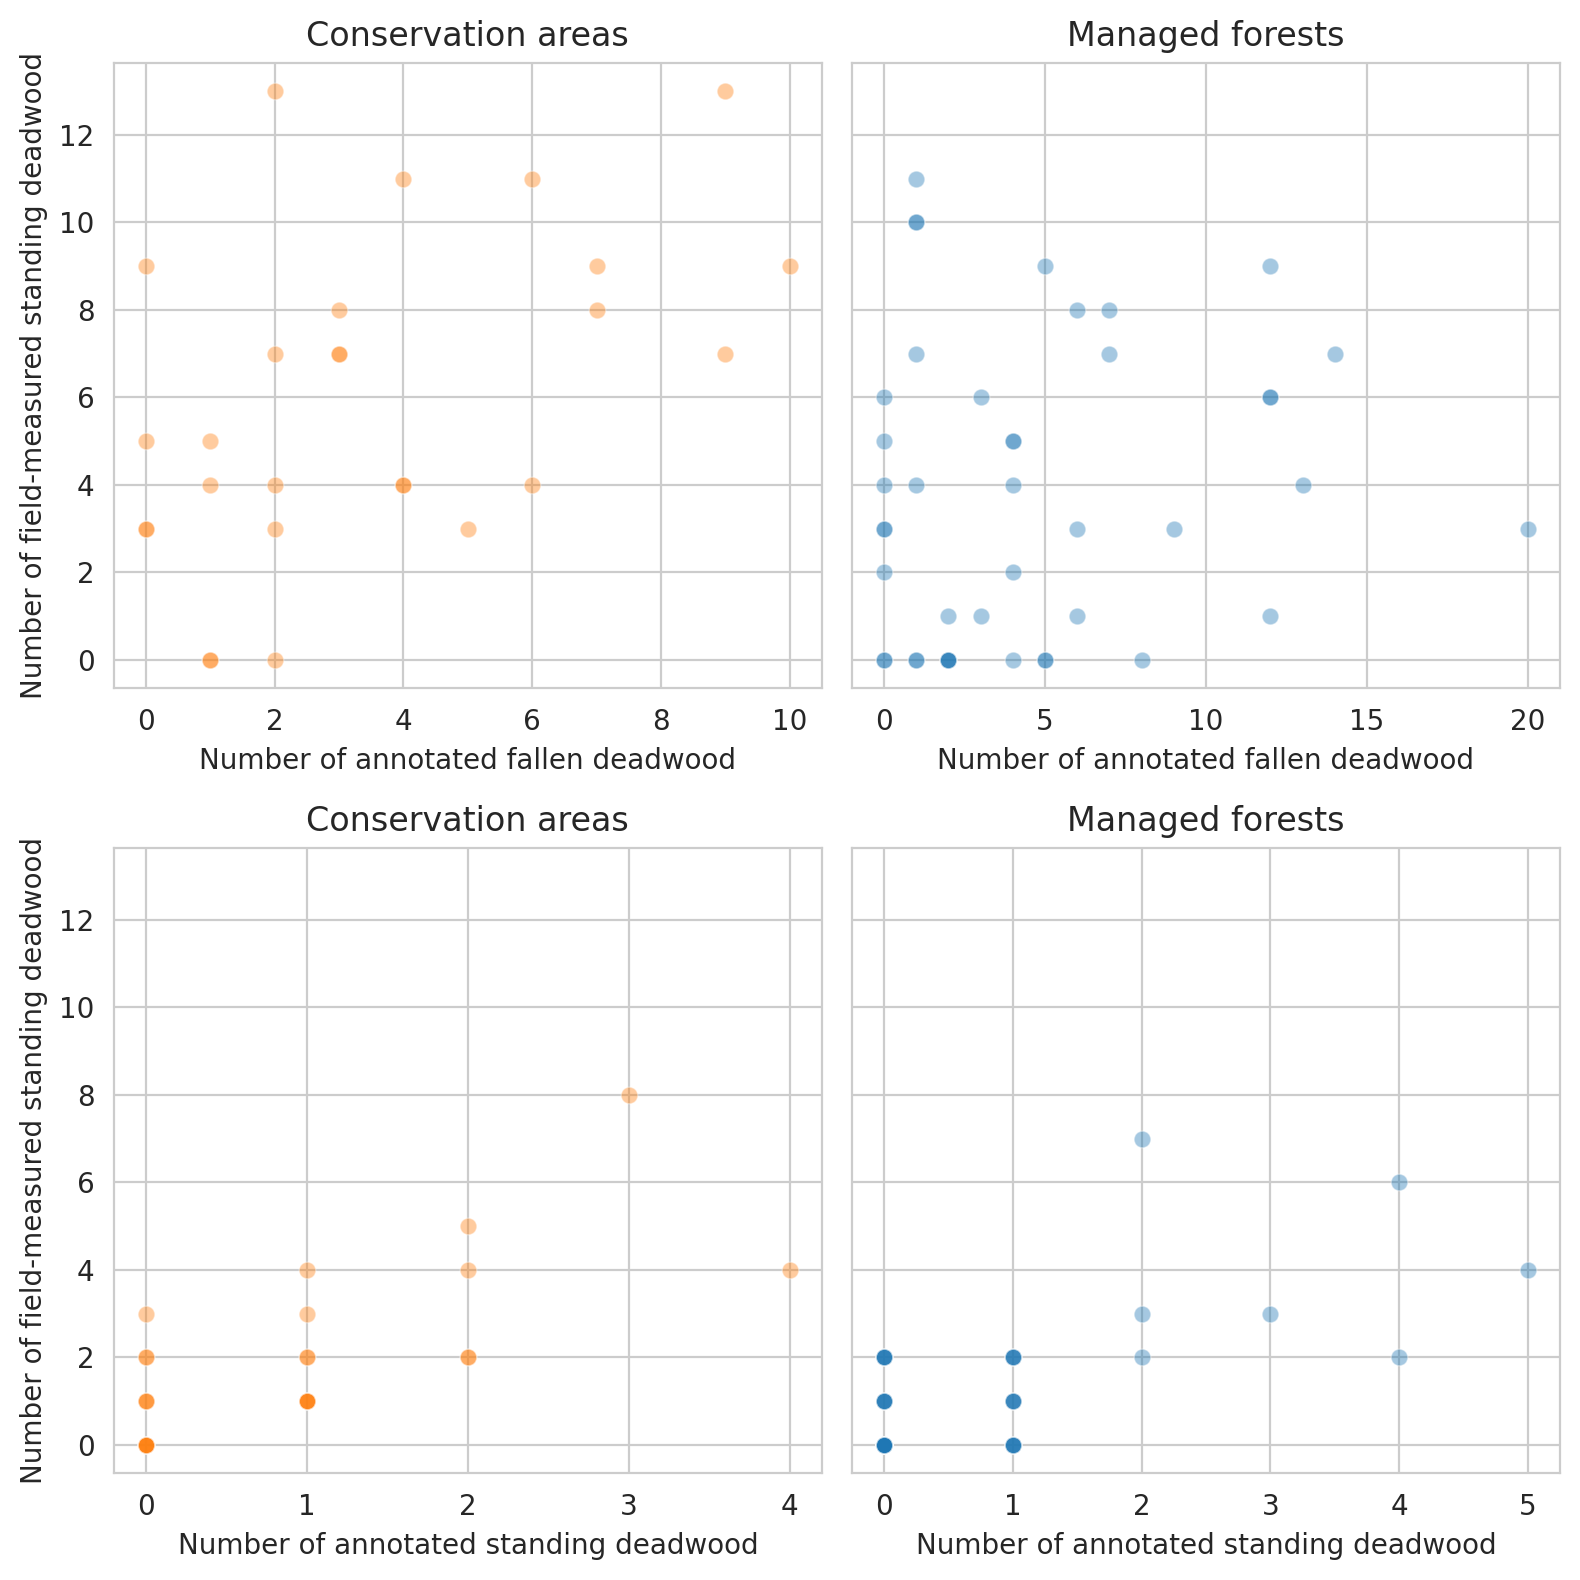

In [142]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=False)
sns.scatterplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], 
                x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,0], 
               alpha=0.4, color='tab:orange')
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured standing deadwood')
sns.scatterplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], 
                x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,1], alpha=0.4, color='tab:blue')
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('Number of field-measured fallen deadwood')


sns.scatterplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], 
             x='n_dw_stand_ann', y='n_dw_stand_field', ax=ax[1,0], alpha=0.4, color='tab:orange')
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')

sns.scatterplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], 
            x='n_dw_stand_ann', y='n_dw_stand_field', ax=ax[1,1],  alpha=0.4, color='tab:blue')
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('Number of field-measured standing deadwood')
plt.tight_layout()

Plot the total lengths of groundwood located within a single field plot.

In [143]:
plot_dw_data['l_gw_field'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id == row.id) &
                                                                      (tree_data.tree_class == 4)].l.sum()
                                              , axis=1)
plot_dw_data['l_gw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer_1 == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

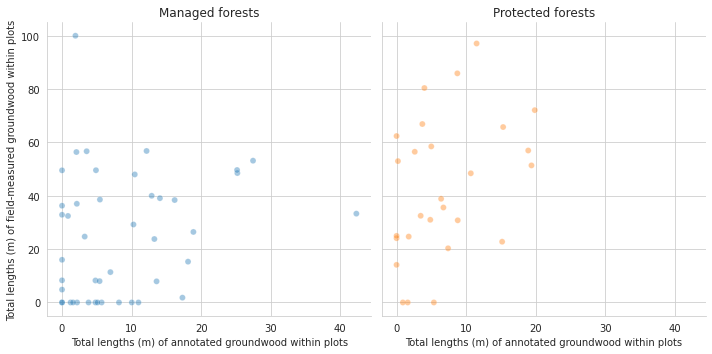

In [150]:
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_gw_field', col='conservation', hue='conservation', alpha=.4,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

## Sudenpesänkangas

Read data and do some wrangling.

In [76]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_plots = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_natura = gpd.read_file(evo_fd_path/'sudenpesankangas_natura.geojson')
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

In [77]:
evo_anns = evo_anns.overlay(evo_plots)

In [78]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [79]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(evo_natura.geometry.contains(row.geometry))
                                                        else 0, axis=1)

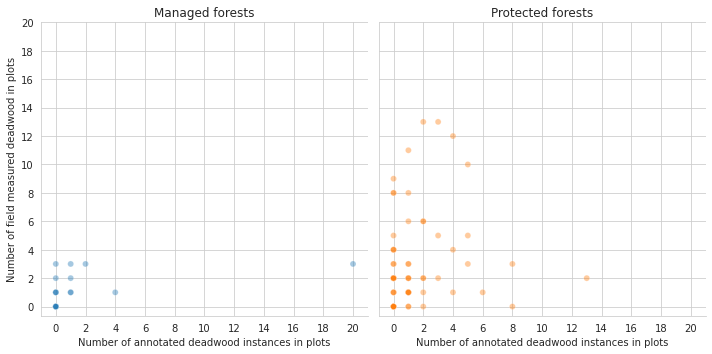

In [152]:
g = sns.relplot(data=evo_plots, x='n_dw_ann', y='n_dw_plot', col='conservation', hue='conservation', alpha=.4,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Number of field measured deadwood in plots')
g.set_xlabels('Number of annotated deadwood instances in plots')
g.axes[0,0].set_yticks(range(0,21,2))
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
plt.show()

As before, darker dots signify more plots having the same relation.

In [81]:
evo_plots['n_dw_fall'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.puuluo == 4) & (evo_field_data.plotid==row.id)]), axis=1)
evo_plots['n_dw_standing'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.puuluo == 3) & (evo_field_data.plotid==row.id)]), axis=1)
evo_plots['n_dw_both'] = evo_plots.n_dw_fallen + evo_plots.n_dw_standing

In [91]:
evo_plots['n_dw_stand_field'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.plotid == row.id) &
                                                                               (evo_field_data.puuluo == 3)]),
                                               axis=1)
evo_plots['n_dw_fall_field'] = evo_plots.apply(lambda row: len(evo_field_data[(evo_field_data.plotid == row.id) &
                                                                              ((evo_field_data.puuluo == 4)|
                                                                               (evo_field_data.puuluo == 5))]),
                                               axis=1)
evo_plots['n_dw_stand_ann'] = evo_plots.apply(lambda row: len(evo_anns[(evo_anns.plot_id == row.id) &
                                                                       (evo_anns.label != 'groundwood')]),
                                              axis=1)
evo_plots['n_dw_fall_ann'] = evo_plots.apply(lambda row: len(evo_anns[(evo_anns.plot_id == row.id) &
                                                                      (evo_anns.label == 'groundwood')]),
                                             axis=1)

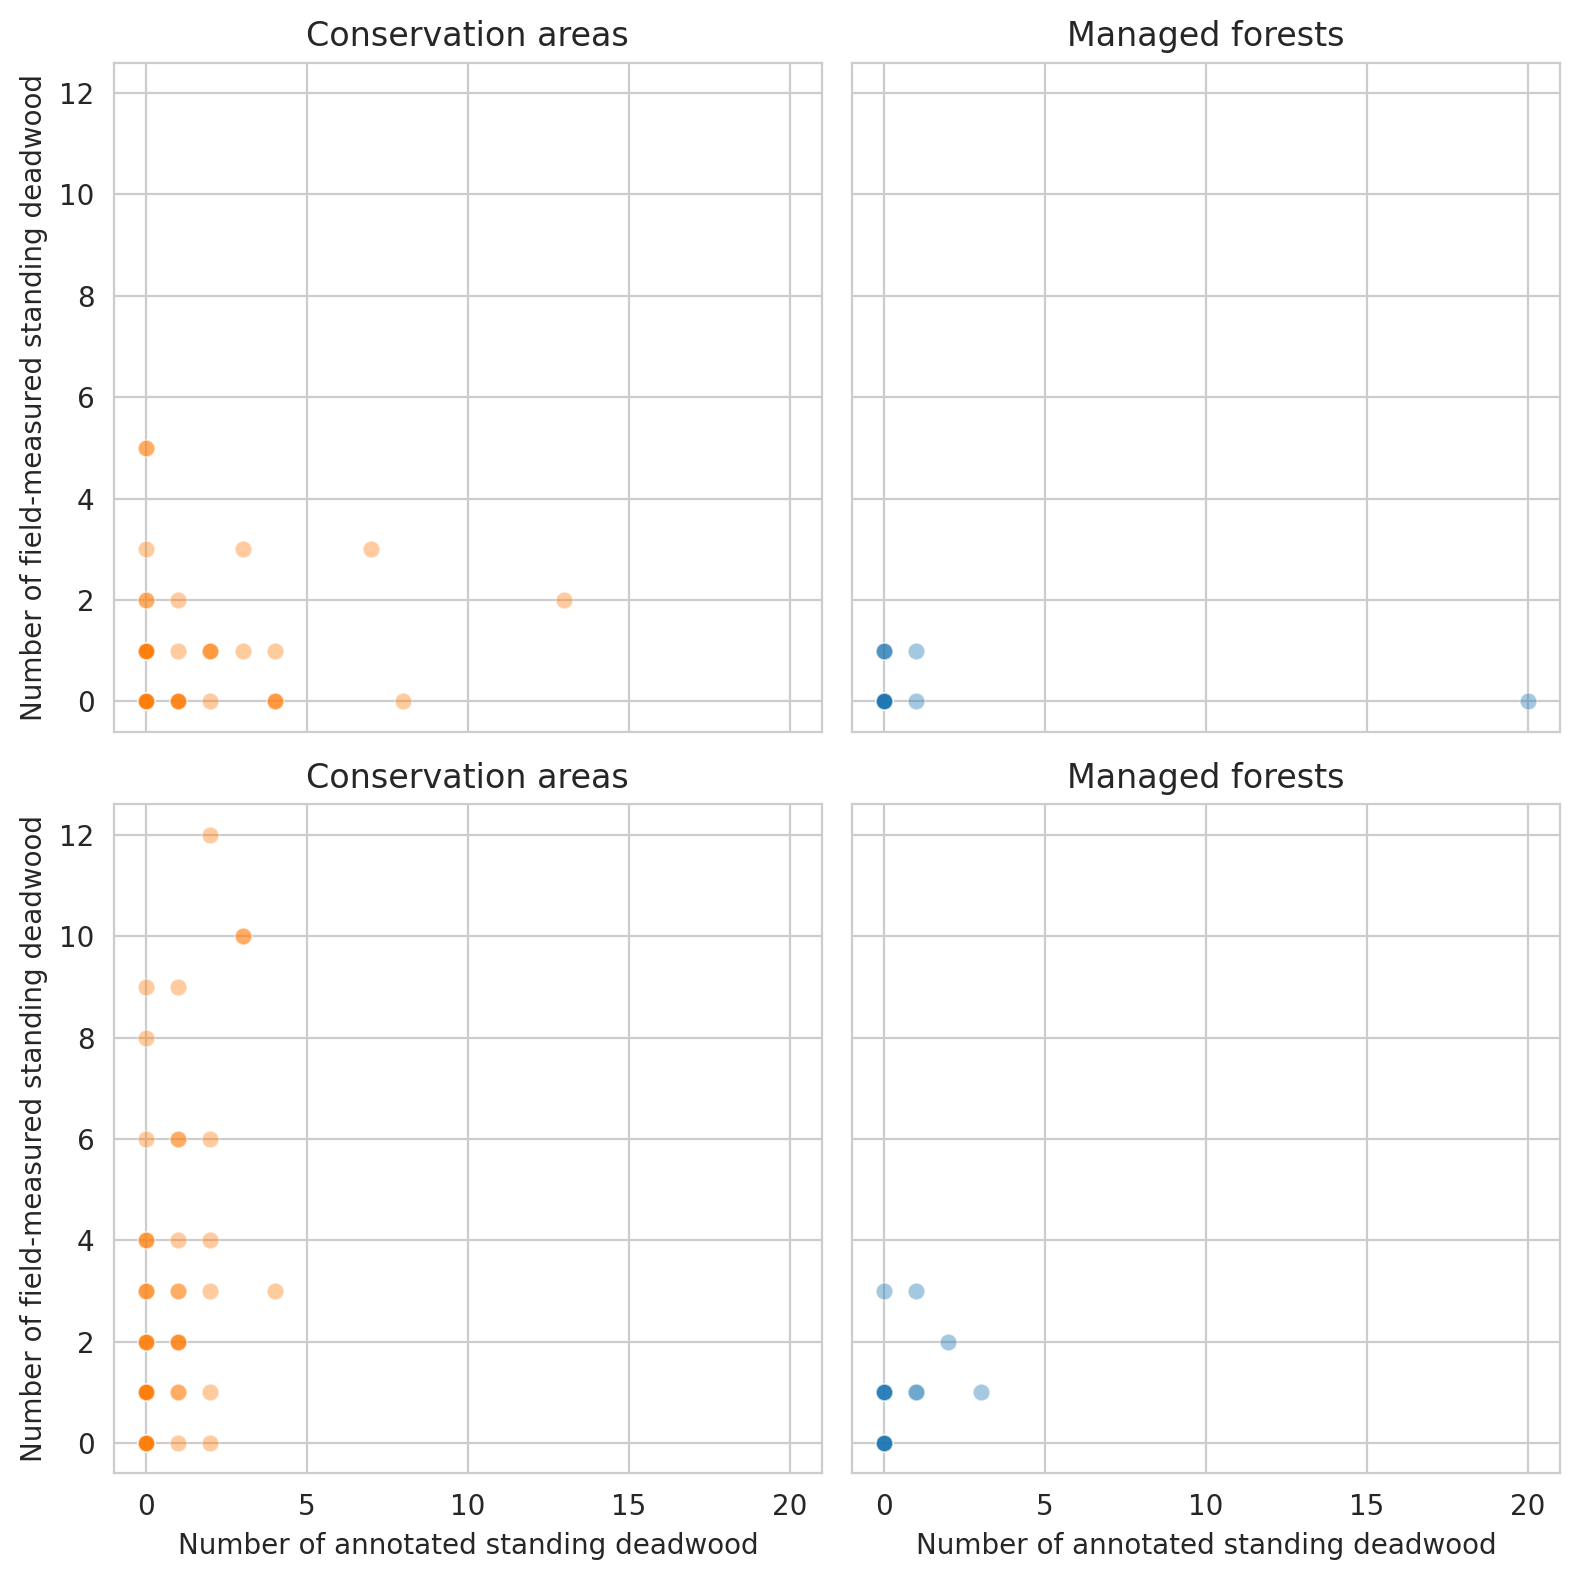

In [96]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.scatterplot(data=evo_plots[(evo_plots.conservation == 1)], 
                x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,0], 
               alpha=0.4, color='tab:orange')
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured standing deadwood')
sns.scatterplot(data=evo_plots[(evo_plots.conservation == 0)], 
                x='n_dw_fall_ann', y='n_dw_fall_field', ax=ax[0,1], alpha=0.4, color='tab:blue')
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('Number of field-measured fallen deadwood')


sns.scatterplot(data=evo_plots[(evo_plots.conservation == 1)], 
             x='n_dw_stand_ann', y='n_dw_stand_field', ax=ax[1,0], alpha=0.4, color='tab:orange')
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')

sns.scatterplot(data=evo_plots[(evo_plots.conservation == 0)], 
            x='n_dw_stand_ann', y='n_dw_stand_field', ax=ax[1,1],  alpha=0.4, color='tab:blue')
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('Number of field-measured standing deadwood')
plt.tight_layout()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship.